# 模型的构建与实验分析

In [2]:
import warnings
# Ignore the warnings: https://github.com/jupyter/notebook/issues/2239
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import scipy
import pywt

from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.datasets import load_iris, load_digits, load_boston
from sklearn import linear_model

导入数据集

In [3]:
df_dataset = pd.read_csv('data_output_0305_0725.csv', index_col=0)
df_dataset.index = range(len(df_dataset))
df_dataset.head()

,date,cowshed,avg_actual,avg_milk,THI,calving_days,calving_indices
0,2017-3-5,B4-3S,40.361446,26.7,9.2360,154.5,2.0
1,2017-3-6,B4-3S,38.253012,26.1,9.4780,153.0,2.0
2,2017-3-7,B4-3S,39.644970,26.6,9.4054,154.0,2.0
3,2017-3-8,B4-3S,38.961039,27.3,9.4054,158.0,2.0
4,2017-3-9,B4-3S,38.260870,27.0,10.2440,147.0,2.0


## 数据集预处理

根据不同的建模方式，进行特征处理，构造数据集。

In [4]:
pd.set_option('display.max_rows', 100)
# fields：希望使用的特征构成的list
# ws：window size，是回顾历史的天数（含当天）
# dwt：为True时，采用离散小波变换的方式，而不是直接拼接的方式，处理多日的头均采食量序列数据。
def construct_dataset(df_dataset, fields, ws=1, dwt=False):
    samples_X = []
    samples_y = []
    
    #dataset = df_dataset.values
    ws_with_target = ws + 1
    length = len(df_dataset)
    
    # 对照组的误差。对照组采用最简单直接的策略，以当天的头均采食量直接作为第二天头均采食量的预测值。
    naive_errors = []
    
    for k in xrange(length + 1 - ws_with_target):
        #print 'k:', k
        index_train_s = k
        index_train_e = k + ws_with_target - 2
        index_target = index_train_e + 1
        
        data_train = df_dataset.iloc[index_train_s:index_train_e+1, :]
        data_all = df_dataset.iloc[index_train_s:index_target+1, :]
        y = df_dataset.iloc[index_target]['avg_actual']
        
        # The selected lines should correspond to the same cowshed.
        if not len(data_all['cowshed'].value_counts()) == 1:
            continue

        # Neglect incomplete data
        if pd.isnull(df_dataset.loc[index_train_s:index_target, ['avg_actual', 'avg_milk', 'THI', 'calving_days', 'calving_indices']].values).sum() > 0:
            #print k, df_dataset.loc[index_train_s:index_target]
            continue
            
        # Compute naive errors
        if df_dataset.loc[k]['cowshed'] == df_dataset.loc[k+1]['cowshed']:
            error = df_dataset.loc[k+1]['avg_actual'] - df_dataset.loc[k]['avg_actual']
            if not np.isnan(error):
                naive_errors.append(error)
            
        X = np.array([])
    
        # We individually handle each feature
        # You can freely modify the logic of feature construction
        #print data_all
        if 'avg_actual' in fields:
            if not dwt:
                # Either consider only 1 day or consider more days
                #X = np.append(X, data_train['avg_actual'].values)
                X = np.append(X, df_dataset.iloc[index_train_e]['avg_actual'])
            else:
                X = np.append(X, df_dataset.iloc[index_train_e]['avg_actual'])
                
                cA, cD = pywt.dwt(data_train['avg_actual'].values, 'db1')
                cA2, cD2 = pywt.dwt(cA, 'db1')
                #X = np.append(X, list(cA) + list(cD)) # 1-level DWT.
                #X = np.append(X, list(cA2) + list(cD2) + list(cD)) # 2-level DWT. only used when ws=4*m where m is an arbitrary integer
        if 'avg_milk' in fields:
            if not dwt:
                # Either consider more days or 1 day
                #X = np.append(X, data_train['avg_milk'].values)
                X = np.append(X, df_dataset.iloc[index_train_e]['avg_milk'])
            else:
                X = np.append(X, df_dataset.iloc[index_train_e]['avg_milk'])
                
                cA, cD = pywt.dwt(data_train['avg_milk'].values, 'db1')
                cA2, cD2 = pywt.dwt(cA, 'db1')
                X = np.append(X, list(cA) + list(cD)) # 1-level DWT.
                #X = np.append(X, list(cA2) + list(cD2) + list(cD)) # 2-level DWT. only used when ws=4*m where m is an arbitrary integer

        if 'THI' in fields:
            X = np.append(X, [df_dataset.iloc[index_target]['THI']]) # Note that we can know the THI of the next day
        if 'calving_days' in fields:
            X = np.append(X, df_dataset.iloc[index_train_e]['calving_days'])
        if 'calving_indices' in fields:
            X = np.append(X, df_dataset.iloc[index_train_e]['calving_indices'])
        
        #print X
        samples_X.append(X)
        samples_y.append(y)
    
    print 'Naive MAE:', np.mean(np.abs(naive_errors))
    print 'Number of samples:', len(samples_X), len(samples_y)
    print 'Number of features', len(samples_X[0])
    
    return np.array(samples_X), np.array(samples_y)

## 模型训练和预测

定义函数实现8折交叉验证，返回在训练集和测试集上的MAE（平均绝对误差）。

In [5]:
def regression(X, y, MAX_DEPTH=2, N_TREE=150, plot=False):
    #print 'Paras - max_depth, n_enumerators:',
    print (MAX_DEPTH, N_TREE),
    maes = [] # Mean Absolute Errors on the test set
    maes_on_train = []
    
    # The seed of the random number generator.
    # You can randomly choose it.
    # It is used for consistent replay of the experiments
    rng = np.random.RandomState(337)
    
    # 8-folded cross-validation
    kf = KFold(n_splits=8, shuffle=True, random_state=rng)
    
    for train_index, test_index in kf.split(X):
        clf = xgb.XGBRegressor(booster='gbtree', n_estimators=N_TREE, max_depth=MAX_DEPTH)
        xgb_model = clf.fit(X[train_index],y[train_index])

        pred_on_train = xgb_model.predict(X[train_index])
        MAE_on_train = mean_absolute_error(y[train_index], pred_on_train)
        maes_on_train.append(MAE_on_train)
        MRE_on_train = np.mean((np.abs(pred_on_train-y[train_index])) / y[train_index])
        R2_on_train = r2_score(pred_on_train, y[train_index])
        #print 'Train_MAE:', MAE_on_train,
        #print 'Train_MRE:', MRE_on_train,
        #print 'R^2:', R2_on_train

        predictions = xgb_model.predict(X[test_index])
        actuals = y[test_index]

        mae = mean_absolute_error(actuals, predictions)
        maes.append(mae)
        #print 'MAE:', mae,
        #print 'MRE:', np.mean((np.abs(predictions-actuals)) / actuals),
        #print 'R^2:', r2_score(actuals, predictions)
        
        if plot:
            errors = []
            for k in range(len(actuals)):
                errors.append(predictions[k] - actuals[k])
                
            print 'MAE:', np.mean(np.abs(errors))
            print 'std:', np.std(errors)
            #print '>1.5:', np.sum(np.array(errors) > 1.5), len(errors)
            #print '>3:', np.sum(np.array(errors) > 3), len(errors)
            plt.cla()
            plt.hist(errors, bins=100)
            plt.axvline(x=np.mean(np.abs(errors)), color='r', lw=1, ls='--', label='MAE')
            plt.axvline(x=1.1590, color='orange', lw=1, ls='--', label='control group MAE')
            plt.xlabel('Error (predicted value - actual value)')
            plt.title('Mean Absolute Error')
            plt.legend()
            plt.show()

            #plot_trees(xgb_model)
            xgb.plot_importance(xgb_model)
            plt.show()
            break  # 如果绘图的话，可不跑完所有交叉验证，只跑其中的一次实验，作为样例观察误差分布图像
    
    
    if plot:
        print '======================================='
        print 'average Train_mae', np.mean(maes_on_train)
        print 'average mae:', np.mean(maes)
        
    return np.mean(maes_on_train), np.mean(maes)


In [6]:
# Try various combinations of model parameters
def regression_GS(X, y):
    print '=========== Start regression with grid-searching the parameter space ==========='
    depths = [1, 2, 3, 4, 5]
    n_trees = [75, 100, 150, 200, 250, 300]
    result = []  # result stores the MAE on the training data and the test data for each run of cross-validation experiments
    
    for depth in depths:
        MAX_DEPTH = depth
        tmp = []
        for n_tree in n_trees:
            N_TREE = n_tree

            mae_train, mae = regression(X, y, MAX_DEPTH, N_TREE)
            tmp.append([mae_train, mae])
    
        result.append(tmp)
    
    # Generate codes for LaTeX table
    print "\hline"
    print "& \multicolumn{" + str(len(n_trees)) + "}{|c|}{n\_enumerators} \\\\ \cline{2-" + str(len(n_trees) + 1) + "}"
    print "max\_depth & " + " & ".join([str(x) for x in n_trees]) +  "\\\\"
    print "\hline"

    for k, row in enumerate(result):
        print depths[k],
        for i, col in enumerate(row):
            print '&', str(round(col[0], 4)) + '/' + str(round(col[1], 4)),
        print "\\\\"
    print "\hline"
    return min(np.ndarray.flatten(np.array([[col[1] for col in row] for row in result])))

计算得到特征处理后的样本集：X，y。其中X是输入变量，y是输出变量，即预测目标值（第二天的头均采食量）。

In [7]:
fields = ['avg_actual', 'avg_milk', 'THI', 'calving_days', 'calving_indices']
X, y = construct_dataset(df_dataset, fields, ws=4, dwt=True)

Naive MAE: 1.14486397451
Number of samples: 1897 1897
Number of features 9


导出训练好的模型为文件：

In [8]:
import pickle

# Save the model
clf = xgb.XGBRegressor(booster='gbtree', n_estimators=100, max_depth=4)
xgb_model = clf.fit(X, y)
print xgb_model
pickle.dump(xgb_model, open("model.pickle.dat", "wb"))

# Load the model
clf = pickle.load(open("model.pickle.dat", "rb"))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


调用regression函数对参数空间进行枚举搜索，探索使预测性能最优的参数配置。

In [9]:
print regression_GS(np.array(X), np.array(y))

=========== Start regression with grid-searching the parameter space ===========
(1, 75) (1, 100) (1, 150) (1, 200) (1, 250) (1, 300) (2, 75) (2, 100) (2, 150) (2, 200) (2, 250) (2, 300) (3, 75) (3, 100) (3, 150) (3, 200) (3, 250) (3, 300) (4, 75) (4, 100) (4, 150) (4, 200) (4, 250) (4, 300) (5, 75) (5, 100) (5, 150) (5, 200) (5, 250) (5, 300) \hline
& \multicolumn{6}{|c|}{n\_enumerators} \\ \cline{2-7}
max\_depth & 75 & 100 & 150 & 200 & 250 & 300\\
\hline
1 & 1.1048/1.1484 & 1.0839/1.1333 & 1.0639/1.1217 & 1.0532/1.1158 & 1.047/1.1138 & 1.0425/1.1123 \\
2 & 1.027/1.1041 & 1.0059/1.0982 & 0.9747/1.0931 & 0.9499/1.0925 & 0.9284/1.0926 & 0.9094/1.0953 \\
3 & 0.9544/1.0892 & 0.9233/1.0856 & 0.8686/1.0875 & 0.8209/1.0903 & 0.7818/1.0953 & 0.7452/1.1013 \\
4 & 0.8731/1.079 & 0.8246/1.0788 & 0.7413/1.0849 & 0.6702/1.0906 & 0.6122/1.0976 & 0.5576/1.1024 \\
5 & 0.7812/1.0858 & 0.7131/1.0881 & 0.6014/1.0985 & 0.5085/1.1049 & 0.4325/1.1154 & 0.372/1.1231 \\
\hline
1.07876371651


给定参数配置，绘制图像观察绝对误差的分布情况，以及不同特征的重要程度。

(4, 100) MAE: 1.09974406338
std: 1.44466110887


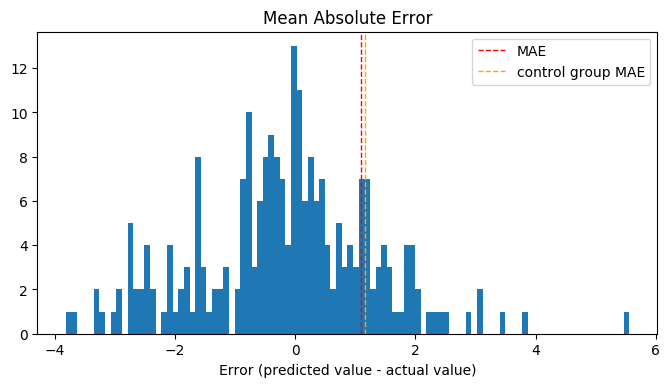

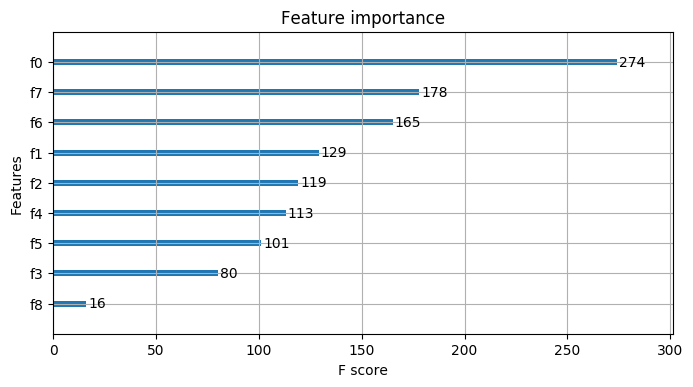

average Train_mae 0.814691119199
average mae: 1.09974406338


(0.81469111919906112, 1.0997440633767905)

In [10]:
regression(X, y, MAX_DEPTH=4, N_TREE=100, plot=True)